<a href="https://colab.research.google.com/github/farrukh602/Deep-Learning-Course/blob/main/D2L_Object_detection2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import os
from typing import NamedTuple
import json
# import einops
# from einops.layers.torch import Rearrange
import tensorflow as tf
# import od

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!/usr/bin/env python
# coding: utf-8

# In[109]:


import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import os
from typing import NamedTuple
import json
import einops
from einops.layers.torch import Rearrange
import tensorflow as tf


def box_corner_to_center(boxes):
    """Convert from (upper-left, lower-right) to (center, width, height)."""
    x1, y1, x2, y2 = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx = (x1 + x2) / 2
    cy = (y1 + y2) / 2
    w = x2 - x1
    h = y2 - y1
    boxes = torch.stack((cx, cy, w, h), axis=-1)
    return boxes


def box_center_to_corner(boxes):
    """Convert from (center, width, height) to (upper-left, lower-right)."""
#     cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    cx, cy, w, h = boxes[0], boxes[1], boxes[2], boxes[3]
    x1 = torch.tensor(cx - 0.5 * w)
    y1 = torch.tensor(cy - 0.5 * h)
    x2 = torch.tensor(cx + 0.5 * w)
    y2 = torch.tensor(cy + 0.5 * h)
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes

def box_dimension_to_corner(boxes):
    """Convert from (center, width, height) to (upper-left, lower-right)."""
#     cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x_l, y_l, w, h = boxes[0], boxes[1], boxes[2], boxes[3]
    x1 = torch.tensor(x_l)
    y1 = torch.tensor(y_l)
    x2 = torch.tensor(x_l+w)
    y2 = torch.tensor(y_l + h)
    boxes = torch.stack((x1, y1, x2, y2), axis=-1)
    return boxes




def multibox_prior(data, sizes, ratios):
    """Generate anchor boxes with different shapes centered on each pixel."""
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)
    # Offsets are required to move the anchor to the center of a pixel. Since
    # a pixel has height=1 and width=1, we choose to offset our centers by 0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height  # Scaled steps in y axis
    steps_w = 1.0 / in_width  # Scaled steps in x axis

    # Generate all center points for the anchor boxes
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # Generate `boxes_per_pixel` number of heights and widths that are later
    # used to create anchor box corner coordinates (xmin, xmax, ymin, ymax)
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                   * in_height / in_width  # Handle rectangular inputs
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))
    # Divide by 2 to get half height and half width
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(
                                        in_height * in_width, 1) / 2

    # Each center point will have `boxes_per_pixel` number of anchor boxes, so
    # generate a grid of all anchor box centers with `boxes_per_pixel` repeats
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

def show_bboxes(axes, bboxes, labels=None, colors=None):
    """Show bounding boxes."""

    def make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = make_list(labels)
    colors = make_list(colors, ['b', 'g', 'r', 'm', 'c'])

    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                                 linewidth=2, edgecolor=color, facecolor='none')
        axes.add_patch(rect)

        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            text_x = (bbox[0] + bbox[2]) / 2
            text_y = (bbox[1] + bbox[3]) / 2
            axes.text(text_x, text_y, labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))



###Inter setction over union

# def box_iou(y_true_list, y_pred_list):
#     ious = []

#     for y_true in y_true_list:
#         for y_pred in y_pred_list:
#             x1 = max(y_true[0], y_pred[0])
#             y1 = max(y_true[1], y_pred[1])
#             x2 = min(y_true[2], y_pred[2])
#             y2 = min(y_true[3], y_pred[3])

#             intersection_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)

#             true_area = (y_true[2] - y_true[0] + 1) * (y_true[3] - y_true[1] + 1)
#             bbox_area = (y_pred[2] - y_pred[0] + 1) * (y_pred[3] - y_pred[1] + 1)

#             iou = intersection_area / float(true_area + bbox_area - intersection_area)
#             ious.append(iou)

    # Filter out IoU values greater than 0.5
#     ious = [iou for iou in ious if iou >= 0.5]

#     return torch.tensor(ious)

#@save
def box_iou(boxes1, boxes2):
    """Compute pairwise IoU across two lists of anchor or bounding boxes."""
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    # Shape of `boxes1`, `boxes2`, `areas1`, `areas2`: (no. of boxes1, 4),
    # (no. of boxes2, 4), (no. of boxes1,), (no. of boxes2,)
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    # Shape of `inter_upperlefts`, `inter_lowerrights`, `inters`: (no. of
    # boxes1, no. of boxes2, 2)
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
    # Shape of `inter_areas` and `union_areas`: (no. of boxes1, no. of boxes2)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas
# Assign Anchor to boxes

def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """Assign closest ground-truth bounding boxes to anchor boxes."""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # Element x_ij in the i-th row and j-th column is the IoU of the anchor
    # box i and the ground-truth bounding box j
    jaccard = box_iou(anchors, ground_truth)
    # Initialize the tensor to hold the assigned ground-truth bounding box for
    # each anchor
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                  device=device)
    # Assign ground-truth bounding boxes according to the threshold
#     max_ious, indices = torch.max(jaccard, dim=1)
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)
    box_j = indices[max_ious >= iou_threshold]
    anchors_bbox_map[anc_i] = box_j
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)  # Find the largest IoU
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

# def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.01):
#     num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
#     jaccard = box_iou(anchors, ground_truth)  # Assuming you have a box_iou function

#     anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long, device=device)

#     # Assign ground-truth bounding boxes according to the threshold
#     max_ious, indices = torch.max(jaccard, dim=0)
#     gt_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)
#     box_j = indices[max_ious >= iou_threshold]

#     # Assign each ground-truth bounding box to the anchor box with the highest IoU
#     anchors_bbox_map[gt_i] = box_j
#     return anchors_bbox_map


# offset
#@save
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """Transform for anchor box offsets."""
#     c_anc = d2l.box_corner_to_center(anchors)
    c_anc = box_corner_to_center(anchors)
    c_assigned_bb = box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset


#@save
def multibox_target(anchors, labels):
    """Label anchor boxes using ground-truth bounding boxes."""
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(
            label[:, 1:], anchors, device)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(
            1, 4)
        # Initialize class labels and assigned bounding box coordinates with
        # zeros
        class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                   device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                  device=device)
        # Label classes of anchor boxes using their assigned ground-truth
        # bounding boxes. If an anchor box is not assigned any, we label its
        # class as background (the value remains zero)
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        # Offset transformation
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

# Predicting Bounding Boxes with Non-Maximum Suppression
def offset_inverse(anchors, offset_preds):
    """Predict bounding boxes based on anchor boxes with predicted offsets."""
    anc = box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = box_center_to_corner(pred_bbox)
    return predicted_bbox

def nms(boxes, scores, iou_threshold):
    """Sort confidence scores of predicted bounding boxes."""
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []  # Indices of predicted bounding boxes that will be kept
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1: break
        iou = box_iou(boxes[i, :].reshape(-1, 4),
                      boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)

def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """Predict bounding boxes using non-maximum suppression."""
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)
        # Find all non-`keep` indices and set the class to background
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        # Here `pos_threshold` is a threshold for positive (non-background)
        # predictions
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat((class_id.unsqueeze(1),
                               conf.unsqueeze(1),
                               predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)

def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """Assign closest ground-truth bounding boxes to anchor boxes."""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # Element x_ij in the i-th row and j-th column is the IoU of the anchor
    # box i and the ground-truth bounding box j
    jaccard = box_iou(anchors, ground_truth)
    # Initialize the tensor to hold the assigned ground-truth bounding box for
    # each anchor
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                  device=device)
    # Assign ground-truth bounding boxes according to the threshold
#     max_ious, indices = torch.max(jaccard, dim=1)
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)
    box_j = indices[max_ious >= iou_threshold]
    anchors_bbox_map[anc_i] = box_j
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)  # Find the largest IoU
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map
def multibox_target(anchors, labels):
    """Label anchor boxes using ground-truth bounding boxes."""
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(
            label[:, 1:], anchors, device)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(
            1, 4)
        # Initialize class labels and assigned bounding box coordinates with
        # zeros
        class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                   device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                  device=device)
        # Label classes of anchor boxes using their assigned ground-truth
        # bounding boxes. If an anchor box is not assigned any, we label its
        # class as background (the value remains zero)
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        # Offset transformation
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

def display_anchors(img, fmap_w, fmap_h, s):
#     d2l.set_figsize()
    # Values on the first two dimensions do not affect the output
    fmap = torch.zeros((1, 10, fmap_h, fmap_w))
    anchors = multibox_prior(fmap, sizes=s, ratios=[1, 2, 0.5])
    w,h  = img.width, img.height   # Note: image is loaded as PIL.Image
    bbox_scale = torch.tensor((w, h, w, h))
    show_bboxes(plt.imshow(img).axes,
                    anchors[0] * bbox_scale)



# Multiscalling

In [ ]:
from collections import defaultdict
image_ids_annotations = defaultdict(list)

# load annotations
file_path = r"/content/drive/MyDrive/Deep Learning Course/Project/Datasets/My-Game-Pics-5-COCO/train/_annotations.coco.json"
# Open the file and load JSON data
with open(file_path, 'r') as file:
    anns = json.load(file)
# Add into datastructure


for ann in anns['annotations']:
  image_id = ann['image_id'] # are integers
  image_ids_annotations[image_id].append(ann)   # information of images against image numbers (total image numbers=441)

# Get mapping category_id to category name
catergory_id_to_name = dict()
for ann in anns['categories']:
    catergory_id_to_name[ann['id']] = ann['name']

#image_ids_annotations combine with file name as a key

for image_id in range(len(image_ids_annotations)):
    for i in range(len(image_ids_annotations[image_id])):
        image_ids_annotations[image_id][i]['file_name']=anns['images'][image_id]['file_name']
# image categories
# anns['categories']
categories={1: 'Coyote', 2:'Deer',3:'Hog',4:'Rabbit',5:'Raccoon'}

In [ ]:
image_id=315
# cwd = '/content/drive/MyDrive/Deep Learning Course/Project/setting data and code for multibox detector/test_directory'
cwd=os.getcwd()
image_name=os.path.join(cwd,'test_directory',image_ids_annotations[image_id][0]['file_name'])
img= Image.open(image_name)
img_resized = img.resize((256, 256))

resize_scale_for_bbx=np.array([img_resized.width / img.width,img_resized.height / img.height,
                               img_resized.width / img.width,img_resized.height / img.height])

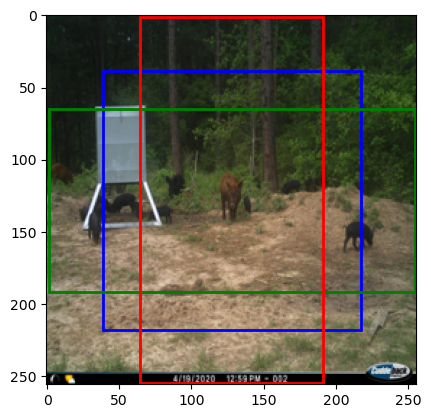

In [ ]:

display_anchors(img_resized, fmap_w=1, fmap_h=1, s=[0.70])

In [ ]:
# Your existing dictionary
original_dict = image_ids_annotations # Replace with your actual dictionary

# Create a new dictionary with 'file_name' as the key
# Create a new dictionary with 'file_name' as the key
# Create a new dictionary with 'file_name' as the key
new_dict = {entry[0].get('file_name', 'unknown'): entry for entry in original_dict.values() if entry}

# Example: Printing the new dictionary
# for file_name, entries in new_dict.items():
#     print(f"{file_name}: {entries}")
len(new_dict)

8056

In [ ]:
### Padded annotations
from collections import defaultdict
import numpy as np

def pad_annotations(annotations_dict):
    # Find the maximum number of annotations in any image
    max_num_annotations = max(len(annotations) for annotations in annotations_dict.values())

    # Pad annotations with category id '-1'
    padded_annotations = defaultdict(lambda: [{'bbox': [0, 0, 0, 0], 'category_id': -1}] * max_num_annotations)

    for image_id, annotations_list in annotations_dict.items():
        # Extract bounding box and category id from each annotation
        annotations = [({'bbox': annot['bbox'], 'category_id': annot['category_id']}) for annot in annotations_list]

        # Slice the annotations to the maximum length and pad if needed
        padded_annotations[image_id][:len(annotations)] = annotations

    return padded_annotations

# Example usage

padded_annotations1 = pad_annotations(new_dict)
# padded_annotations1
# image_ids_annotations

In [ ]:
import csv

def write_annotations_to_csv(annotations, csv_filename):
    with open(csv_filename, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)

        # Write header
        header = ['Image_ID']
        for i in range(len(annotations[0])):
            header.extend([f'Bbox_{i + 1}_X', f'Bbox_{i + 1}_Y', f'Bbox_{i + 1}_W', f'Bbox_{i + 1}_H', f'Category_{i + 1}'])
        csv_writer.writerow(header)

        # Write data
        for image_id, annotation_list in annotations.items():
            row = [image_id]
            for annotation in annotation_list:
                bbox = annotation['bbox']
                category_id = annotation['category_id']
                row.extend(bbox + [category_id])
            csv_writer.writerow(row)

# Example usage
annotations_dict = padded_annotations1  # Your padded annotations dictionary
csv_filename = 'sparse_annotations.csv'
write_annotations_to_csv(annotations_dict, csv_filename)


In [ ]:
!cp '/content/sparse_annotations.csv' '/content/drive/MyDrive/Deep Learning Course/Project/Datasets/My-Game-Pics-5-COCO'

# Get annotations fr image
Get mapping images_id->[annotations_objects]  
Get mapping categor_id -> category_name

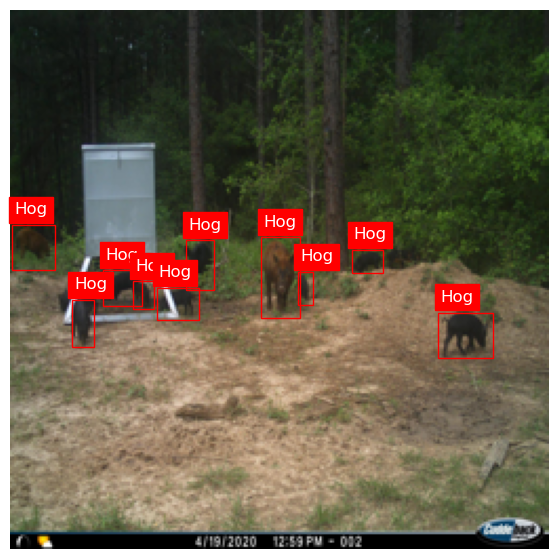

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

image_id=315
# cwd = '/content/drive/MyDrive/Deep Learning Course/Project/setting data and code for multibox detector/test_directory'
cwd=os.getcwd()
image_name=os.path.join(cwd,'test_directory',image_ids_annotations[image_id][0]['file_name'])
img= Image.open(image_name)
# img_resized = img.resize((1600, 1600))
img_resized =  img.resize((256, 256))
resize_scale_for_bbx=np.array([img_resized.width / img.width,img_resized.height / img.height,
                               img_resized.width / img.width,img_resized.height / img.height])

img_np = np.array(img_resized)
plt.rcParams['figure.figsize']=[7,7]
image_id=315
# Add code to visualize boxes and labels
image_anns = image_ids_annotations[image_id]

fig, ax = plt.subplots()

for image_ann in image_anns:
    bbox = image_ann['bbox']  # format: x,y,w,h, with origin in the top-left corner
    name = catergory_id_to_name[image_ann['category_id']]

    # Extract bbox coordinates
    x = float(bbox[0])
    y = float(bbox[1])
    w = float(bbox[2])
    h = float(bbox[3])

    # Resize image
    # img_resized = img.resize((1600, 1600))  # Adjust the size as needed

    # Resize bbox coordinates
    x_resized = x * img_resized.width / img.width
    y_resized = y * img_resized.height / img.height
    w_resized = w * img_resized.width / img.width
    h_resized = h * img_resized.height / img.height

    # Add text and bbox
    plt.text(x_resized + 1, y_resized - 5, name, fontdict={'fontsize': 12.0,
                                                           'fontweight': 'medium', 'color': 'white', 'backgroundcolor': 'red'})
    bb = patches.Rectangle((x_resized, y_resized), w_resized, h_resized, linewidth=1, edgecolor='red', facecolor='none')
    ax.add_patch(bb)


ax.axis('off')
ax.imshow(img_resized)
plt.show()

1

In [ ]:
# Ground truth initialization
ground_truth_list = []
image_id = 315

for i in range(len(image_ids_annotations[image_id])):
    boxes = np.array(box_dimension_to_corner(image_ids_annotations[image_id][i]['bbox']))
    boxes = boxes*resize_scale_for_bbx
    category_id = image_ids_annotations[image_id][i]['category_id']

    # Concatenate scalar category_id with tensor elements
    ground_truth_list.append([category_id] + boxes.tolist())

# Convert the list to a tensor
ground_truth = torch.tensor(ground_truth_list)

anchors = torch.tensor([
    [4.,  626.,  167.,  758.],
    [231.,  845.,  316.,  983.],
    [665.,  671.,  772.,  817.],
    [0.3, 0.3, 0.6, 0.6],
    [1622.,  882., 1831., 1016.],
])/1



# multibox_target function defined above, we can label classes and offsets of these anchor boxes based on
# the ground-truth bounding boxes for the dog and cat
# labels = multibox_target(anchors.unsqueeze(dim=0),
#                          ground_truth.unsqueeze(dim=0))
labels =multibox_target(anchors.unsqueeze(dim=0),
                         ground_truth.unsqueeze(dim=0))
labels

(tensor([[  -4.59,  -43.91,  -10.39,   -9.09,  -28.15,  -55.48,  -10.39,   -9.09,
           -62.19,  -41.95,   -8.71,  -10.74, 2083.94, 4487.05,   17.34,   18.96,
           -78.82,  -60.44,  -11.73,  -10.76]]),
 tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
          1., 1.]]),
 tensor([[4, 4, 4, 4, 4]]))

## Multiscaling

In [ ]:
for i in tf.data.Dataset.from_tensor_slices(labels):
    print(i)

(<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([  -4.5894036,  -43.914024 ,  -10.394726 ,   -9.090479 ,
        -28.152447 ,  -55.48023  ,  -10.394727 ,   -9.090482 ,
        -62.193844 ,  -41.94717  ,   -8.705706 ,  -10.738702 ,
       2083.9414   , 4487.0503   ,   17.344124 ,   18.962946 ,
        -78.81992  ,  -60.438816 ,  -11.730515 ,  -10.757923 ],
      dtype=float32)>, <tf.Tensor: shape=(20,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.], dtype=float32)>, <tf.Tensor: shape=(5,), dtype=int64, numpy=array([4, 4, 4, 4, 4], dtype=int64)>)


In [ ]:
with open(file_path, 'r') as file:
    trn_j = json.load(file)

IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations',
                                 'categories']

FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

cats = dict((o[ID], o['name']) for o in trn_j[CATEGORIES])   # categoreis
trn_fns = dict((o[ID], o[FILE_NAME]) for o in trn_j[IMAGES])  #image file names
trn_ids = [o[ID] for o in trn_j[IMAGES]]   # Image ids
#####################

trn_anno = defaultdict(lambda: [])
for o in trn_j[ANNOTATIONS]:
    bb = o[BBOX]
    bb = np.array(
        [bb[0], bb[1], bb[3]+bb[1]-1, bb[2]+bb[0]-1] # this way we get xmin,ymin and xmax, ymax given xmin,ymin, h,w
                 )
    trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))

In [ ]:
from collections import defaultdict
import numpy as np

def pad_annotations(annotations_dict):
    # Find the maximum number of annotations in any image
    max_num_annotations = max(len(annotations) for annotations in annotations_dict.values())

    # Pad annotations with category id '-1'
    padded_annotations = defaultdict(lambda: [(np.array([0, 0, 0, 0]), -1)] * max_num_annotations)

    for image_id, annotations in annotations_dict.items():
        # Slice the annotations to the maximum length and pad if needed
        padded_annotations[image_id][:len(annotations)] = annotations

    return padded_annotations



padded_annotations = pad_annotations(trn_anno)
padded_annotations


defaultdict(<function __main__.pad_annotations.<locals>.<lambda>()>,
            {0: [(array([255,   0, 479, 643]), 2),
              (array([0, 0, 0, 0]), -1),
              (array([0, 0, 0, 0]), -1),
              (array([0, 0, 0, 0]), -1),
              (array([0, 0, 0, 0]), -1),
              (array([0, 0, 0, 0]), -1),
              (array([0, 0, 0, 0]), -1),
              (array([0, 0, 0, 0]), -1),
              (array([0, 0, 0, 0]), -1),
              (array([0, 0, 0, 0]), -1)],
             1: [(array([266.  , 166.  , 244.29, 323.57]), 2),
              (array([0, 0, 0, 0]), -1),
              (array([0, 0, 0, 0]), -1),
              (array([0, 0, 0, 0]), -1),
              (array([0, 0, 0, 0]), -1),
              (array([0, 0, 0, 0]), -1),
              (array([0, 0, 0, 0]), -1),
              (array([0, 0, 0, 0]), -1),
              (array([0, 0, 0, 0]), -1),
              (array([0, 0, 0, 0]), -1)],
             2: [(array([270.  , 146.  , 259.23, 466.32]), 2),
              